# Wide Receiver  3D Plot

Data visualization is one such area where a large number of libraries have been developed in Python. Among these, Matplotlib is the most popular choice for data visualization. While initially developed for plotting 2-D charts like histograms, bar charts, scatter plots, line plots, etc., Matplotlib has extended its capabilities to offer 3D plotting modules as well. We explore these by plotting wide receiver projected fantasy points based on offensive snap count and number of targets.

The projected fantasy points are created from a simple multiple linear regression using previous year stats to predict stats for an upcoming season. Here, we plot two of the highest correlated features, number of targets and offensive snap counts.

The data used is pulled from a GridironAI dataset which includes season long stats for players starting from 2012. You can learn more about our data sources and how to do analysis with them in the "Learn Python with Fantasy Football" course.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import sklearn.linear_model

from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

In [7]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('https://raw.githubusercontent.com/fantasydatapros/LearnPythonWithFantasyFootball/master/2022/10-Machine%20Learning%20-%20Regression/1-Gridiron%20AI%20Curated%20Dataset%20-%202022.csv')

In [3]:
df = df.groupby(['player_id', 'tm', 'player', 'pos', 'season'], as_index=False)\
    .agg({
    'offensive_snapcount': np.sum,
    'offensive_snapcount_percentage': np.mean,
    'passing_rating': np.mean,
    'passing_yds': np.sum,
    'passing_td': np.sum,
    'passing_att': np.sum,
    'receiving_yds': np.sum,
    'receiving_td': np.sum,
    'receiving_rec': np.sum,
    'receiving_tar': np.sum,
    'rushing_att': np.sum,
    'standard_fantasy_points': np.sum,
    'ppr_fantasy_points': np.sum,
    'half_ppr_fantasy_points': np.sum
})

df = df.loc[(df['season'] >= 2012)]

In [4]:
pd.set_option('chained_assignment', None)

lag_features = ['rushing_att', 
               'receiving_tar', 
               'offensive_snapcount', 
               'offensive_snapcount_percentage',
                'ppr_fantasy_points',
                'passing_rating',
                'passing_att', 
                'passing_td']

for lag in range(1, 6):
    shifted = df.groupby('player_id').shift(lag)
    for column in lag_features:
        df[f'lag_{column}_{lag}'] = shifted[column]

df = df.fillna(-1)

In [5]:
wr_df = df.loc[(df['pos'] == 'WR') & (df['season'] < 2021)]
wr_df = wr_df.loc[wr_df['lag_offensive_snapcount_1'] > 50]

wr_df['lag_offensive_snapcount_norm'] = (wr_df['lag_offensive_snapcount_1'] - wr_df['lag_offensive_snapcount_1'].min()) / (wr_df['lag_offensive_snapcount_1'].max() - wr_df['lag_offensive_snapcount_1'].min())
wr_df['lag_receiving_tar_norm'] = (wr_df['lag_receiving_tar_1'] - wr_df['lag_receiving_tar_1'].min()) / (wr_df['lag_receiving_tar_1'].max() - wr_df['lag_receiving_tar_1'].min())   

MAE: 54.93008319388268
RMSE: 69.036574534556
Equation: y = 24.87 + 296.05x1 + -27.31x2
MAE: 54.93008319388268
RMSE: 69.036574534556
Equation: y = 24.87 + 296.05x1 + -27.31x2


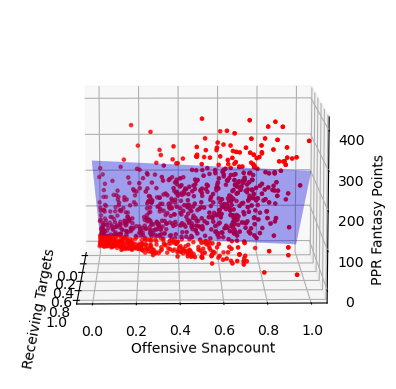

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
def init():

    X = wr_df[['lag_receiving_tar_norm', 'lag_offensive_snapcount_norm']].values#, 'lag_ppr_fantasy_points_1']].values
    y = wr_df['ppr_fantasy_points'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


    ax.scatter(X_train[:,0], X_train[:,1], y_train, marker='.', color='red')
    ax.set_xlabel("Receiving Targets")
    ax.set_ylabel("Offensive Snapcount")
    ax.set_zlabel("PPR Fantasy Points")

    model = sklearn.linear_model.LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("MAE: {}".format(np.abs(y_test-y_pred).mean()))
    print("RMSE: {}".format(np.sqrt(((y_test-y_pred)**2).mean())))

    coefs = model.coef_
    intercept = model.intercept_
    xs = np.tile(np.arange(2), (2,1))
    ys = np.tile(np.arange(2), (2,1)).T
    zs = xs*coefs[0]+ys*coefs[1]+intercept
    print("Equation: y = {:.2f} + {:.2f}x1 + {:.2f}x2".format(intercept, coefs[0],
                                                              coefs[1]))

    ax.plot_surface(xs,ys,zs, alpha=0.2,color='blue')
    return fig,
def animate(i):
    ax.view_init(elev=10., azim=i)
    return fig,
# Animate
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
anim.save('mlr_nfl.mp4', fps=30, extra_args=['-vcodec', 'libx264'])